In [93]:
import numpy as np 
import pandas as pd
import cvxpy as cp 
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize

In [94]:
# Pull 1 years worth of dailiy price data for 4 stocks from yahoo finance
tickers = sorted(['AAPL', 'F', 'VZ', 'KO'])
start = '2016-01-01'
end = '2024-12-31'

data = yf.download(tickers, start, end, )

prices = data['Adj Close']

prices.head()

[*********************100%***********************]  4 of 4 completed


Ticker,AAPL,F,KO,VZ
Date,,,,
2016-01-04 00:00:00+00:00,23.860582,8.669798,32.120052,29.550249
2016-01-05 00:00:00+00:00,23.262651,8.514650,32.233692,29.956108
2016-01-06 00:00:00+00:00,22.807415,8.136081,32.059452,29.685467
2016-01-07 00:00:00+00:00,21.844830,7.881634,31.529169,29.522434
2016-01-08 00:00:00+00:00,21.960340,7.782341,31.445835,29.235487


In [95]:
# Turn the raw price data into a daily returns dataframe
returns = prices.pct_change()
returns.head()

Ticker,AAPL,F,KO,VZ
Date,,,,
2016-01-04 00:00:00+00:00,NaN,NaN,NaN,NaN
2016-01-05 00:00:00+00:00,-0.025059,-0.017895,0.003538,0.013735
2016-01-06 00:00:00+00:00,-0.019569,-0.044461,-0.005406,-0.009035
2016-01-07 00:00:00+00:00,-0.042205,-0.031274,-0.016541,-0.005492
2016-01-08 00:00:00+00:00,0.005288,-0.012598,-0.002643,-0.009720


In [96]:
# Take the average historical return as a expected return vector for testing
# In practice this vector would be computed with signal research
expected_returns = returns.mean()

expected_returns.reset_index().rename(columns={0: 'E[r]'})

,Ticker,E[r]
0,AAPL,0.001174
1,F,0.000385
2,KO,0.000367
3,VZ,0.000223


In [97]:
# Take the historical convariance matrix of the returns dataframe
# In practice this matrix would be forecasted with signal research
covariance_matrix = returns.cov()

covariance_matrix

Ticker,AAPL,F,KO,VZ
Ticker,,,,
AAPL,0.000329,0.000143,0.000076,0.000048
F,0.000143,0.000550,0.000092,0.000066
KO,0.000076,0.000092,0.000131,0.000064
VZ,0.000048,0.000066,0.000064,0.000155


In [98]:
# Formulate optimization problem
# We want to maximize expected return while penalizing variance scaled by our risk aversion (gamma)

def optimal_portfolio(gamma):
    weights = cp.Variable(len(tickers))

    objective = cp.Maximize(weights @ expected_returns - gamma * (weights.T @ covariance_matrix @ weights))

    problem = cp.Problem(objective)
    problem.solve()

    return weights.value

In [99]:
# Generate optimal portfolios fo different levels of gamma

optimal_portfolios = []

for gamma in range(1,11):

    optimal_weights = optimal_portfolio(gamma)

    expected_return = optimal_weights @ expected_returns
    volatility = np.sqrt(optimal_weights.T @ covariance_matrix @ optimal_weights)
    sharpe = expected_return / volatility

    result = list(optimal_weights) + [gamma, expected_return, volatility, sharpe]

    optimal_portfolios.append(result)

headers = tickers + ['Gamma', 'E[r]', 'Vol', 'Sharpe']
df = pd.DataFrame(data=optimal_portfolios, columns=headers)

df

,AAPL,F,KO,VZ,Gamma,E[r],Vol,Sharpe
0,1.744483,-0.194023,0.505608,0.049406,1,0.002170,0.032937,0.065874
1,0.872242,-0.097011,0.252804,0.024703,2,0.001085,0.016468,0.065874
2,0.581494,-0.064674,0.168536,0.016469,3,0.000723,0.010979,0.065874
3,0.436121,-0.048506,0.126402,0.012351,4,0.000542,0.008234,0.065874
4,0.348897,-0.038805,0.101122,0.009881,5,0.000434,0.006587,0.065874
5,0.290747,-0.032337,0.084268,0.008234,6,0.000362,0.005489,0.065874
6,0.249212,-0.027718,0.072230,0.007058,7,0.000310,0.004705,0.065874
7,0.218060,-0.024253,0.063201,0.006176,8,0.000271,0.004117,0.065874
8,0.193831,-0.021558,0.056179,0.005490,9,0.000241,0.003660,0.065874
9,0.174448,-0.019402,0.050561,0.004941,10,0.000217,0.003294,0.065874


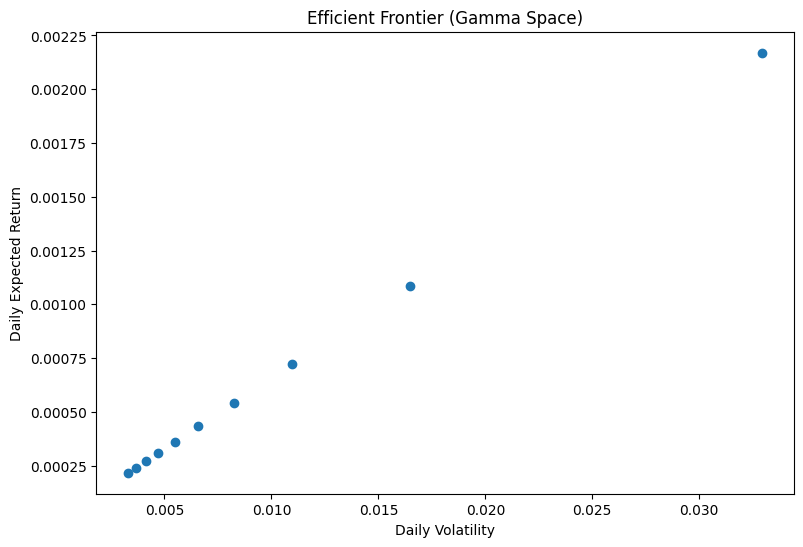

In [100]:
plt.figure(figsize=(9,6))
plt.title("Efficient Frontier (Gamma Space)")
plt.ylabel("Daily Expected Return")
plt.xlabel("Daily Volatility")
plt.scatter(df['Vol'], df['E[r]'])
plt.show()

Notice that all of these portfolios have the same sharpe ratio. Our gamma value scales the leverage that we apply to the portfolio.

In [101]:
# In order to get the optimal portfolio weights for a fully invested portfolio
# we first get the optimal weights for some arbitrary level of gamma
# and then we scale the weights so that they sum to 1

optimal_portfolio_weights = optimal_portfolio(1) / np.sum(optimal_portfolio(1))

optimal_expected_return = optimal_portfolio_weights @ expected_returns
optimal_volatility = np.sqrt(optimal_portfolio_weights.T @ covariance_matrix @ optimal_portfolio_weights)
optimal_sharpe = optimal_expected_return / optimal_volatility

In [102]:
# Here we use scipy to minimize the volalitity while keeping a target return
# This will allow us to graph the efficient frontier

def volatility(weights, covariance_matrix):
    return np.sqrt(np.dot(weights, np.dot(covariance_matrix, weights)))

def mve_portfolio(target_return, covariance_matrix, expected_returns):
    n = len(expected_returns)
    
    objective = lambda weights: volatility(weights, covariance_matrix)
    
    constraints = ({'type': 'eq', 'fun': lambda x: np.dot(x, expected_returns) - target_return},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    
    result = minimize(objective, n * [1 / n], method='SLSQP', constraints=constraints)
    
    return result.x

In [103]:
# Generate a bunch of mean variance efficient portfolios
mve_portfolios = []

target_returns = np.linspace(0, 2 * optimal_expected_return, 100)

for target_return in target_returns:

    optimal_weights = mve_portfolio(target_return, covariance_matrix, expected_returns)

    expected_return = np.dot(optimal_weights, expected_returns)
    vol = np.sqrt(np.dot(optimal_weights, np.dot(covariance_matrix, optimal_weights)))
    sharpe = expected_return / vol
    
    result = list(optimal_weights) + [expected_return, vol, sharpe]
    mve_portfolios.append(result)

headers = tickers + ['E[r]', 'Vol', 'Sharpe']
df = pd.DataFrame(data=mve_portfolios, columns=headers)

df

,AAPL,F,KO,VZ,E[r],Vol,Sharpe
0,-0.334581,0.098664,0.546682,0.689234,9.449906e-16,0.012748,7.412644e-14
1,-0.310940,0.094839,0.539511,0.676590,2.081804e-05,0.012496,1.666040e-03
2,-0.287300,0.091014,0.532340,0.663945,4.163608e-05,0.012251,3.398580e-03
3,-0.263659,0.087189,0.525169,0.651301,6.245412e-05,0.012015,5.197857e-03
4,-0.240018,0.083364,0.517997,0.638658,8.327216e-05,0.011789,7.063507e-03
...,...,...,...,...,...,...,...
95,1.911637,-0.263614,-0.138215,-0.509808,1.977714e-03,0.032222,6.137847e-02
96,1.935277,-0.267402,-0.145427,-0.522449,1.998532e-03,0.032610,6.128671e-02
97,1.958918,-0.271191,-0.152638,-0.535089,2.019350e-03,0.032998,6.119623e-02
98,1.982558,-0.274981,-0.159848,-0.547729,2.040168e-03,0.033387,6.110704e-02


In [104]:
# Create a datafrmae of the individual asset properties

expected_returns = expected_returns.to_numpy()
volatilities = np.sqrt(covariance_matrix.to_numpy().diagonal())
sharpes = expected_returns / volatilities

stocks = pd.DataFrame(
    data=[expected_returns, volatilities, sharpes], 
    columns=tickers
    )
stocks = stocks.T.rename(columns={0: 'expected_return', 1: 'volatility', 2: 'sharpe'})

stocks

,expected_return,volatility,sharpe
AAPL,0.001174,0.018140,0.064708
F,0.000385,0.023459,0.016417
KO,0.000367,0.011454,0.032066
VZ,0.000223,0.012449,0.017943


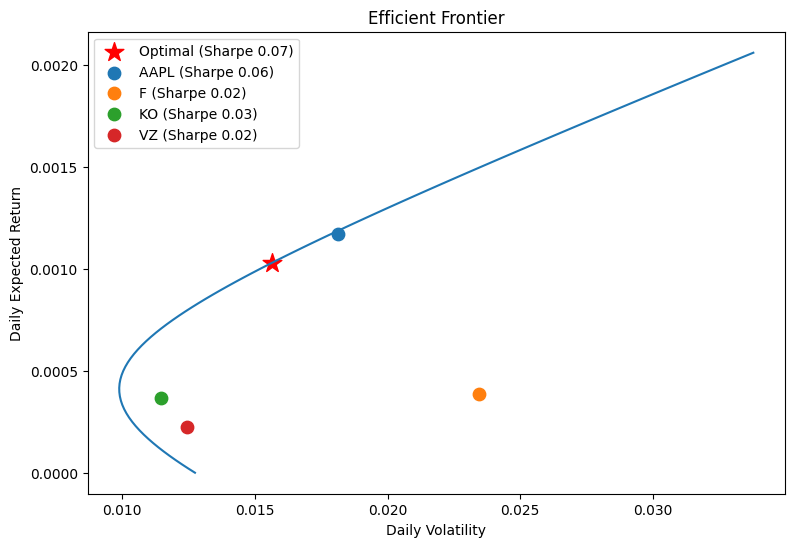

In [105]:
# Plot the efficient frontier

plt.figure(figsize=(9,6))
plt.title("Efficient Frontier")
plt.ylabel("Daily Expected Return")
plt.xlabel("Daily Volatility")

# MVE Portfolios
plt.plot(df['Vol'], df['E[r]'])

# Optimal Portfolio
plt.scatter(optimal_volatility,optimal_expected_return, marker="*", color='red', s=200, label=f"Optimal (Sharpe {round(optimal_sharpe,2)})")

# Individual assets
for index, stock in stocks.iterrows():
    plt.scatter(stock['volatility'], stock['expected_return'], label=f"{index} (Sharpe {round(stock['sharpe'],2)})", s=80)

plt.legend()
plt.show()